In [1]:
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# Create the model class

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(start_dim=0),
            # Encoder
            nn.Linear(in_features=256*256*3, out_features=1024), 
            nn.ReLU(),
            # nn.Linear(in_features=1024, out_features=512),
            nn.Linear(in_features=1024, out_features=784),
            
            
            # nn.ReLU(),
            # nn.Linear(in_features=512, out_features=256),
            # nn.ReLU(),
            # nn.Linear(in_features=256, out_features=128), # -> latent space: 256 -> 128
        )

        self.decoder = nn.Sequential(
            # nn.Linear(in_features=128, out_features=256), 
            # nn.ReLU(),
            # nn.Linear(in_features=256, out_features=512),
            # nn.ReLU(),


            nn.Linear(in_features=784, out_features=1024),
            # nn.Linear(in_features=512, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=256*256*3),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



auto_encoder_model = AutoEncoder().to(device)

In [3]:
from PIL import Image

image = Image.open('image.jpg')
image.width, image.height

from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor()
])

image = image_transform(image)

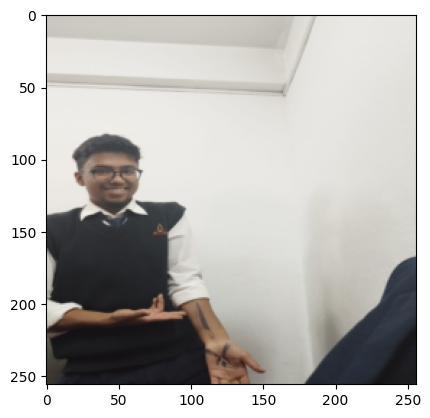

In [4]:
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))

In [5]:
model_output = auto_encoder_model(image.to(device))

In [6]:
model_output

tensor([ 0.0631,  0.0601, -0.0666,  ...,  0.0085, -0.0713, -0.0037],
       device='cuda:0', grad_fn=<ViewBackward0>)

In [7]:
model_output_reshaped = model_output.reshape(3, 256, 256)

In [8]:
model_output_reshaped

tensor([[[ 0.0631,  0.0601, -0.0666,  ...,  0.0084,  0.0099, -0.0775],
         [ 0.0031,  0.1080, -0.0203,  ..., -0.0029, -0.0496,  0.0185],
         [ 0.0495,  0.0356,  0.0422,  ...,  0.0267,  0.0555, -0.0788],
         ...,
         [ 0.0366,  0.0557, -0.0160,  ..., -0.0209, -0.0078, -0.0452],
         [-0.0130, -0.0125, -0.0221,  ...,  0.0315, -0.0117,  0.0004],
         [ 0.0086,  0.0054, -0.1003,  ..., -0.0167, -0.0258, -0.0824]],

        [[-0.0149, -0.0394, -0.0877,  ..., -0.0494, -0.0878, -0.0245],
         [-0.0358,  0.0353, -0.0311,  ..., -0.0157,  0.0526, -0.0241],
         [ 0.0031, -0.0982, -0.0569,  ...,  0.0040,  0.0288,  0.0032],
         ...,
         [ 0.0148,  0.0185, -0.0238,  ...,  0.0046, -0.0460, -0.0007],
         [ 0.0578, -0.0306, -0.0181,  ...,  0.0021,  0.1025, -0.0023],
         [-0.0468,  0.0247, -0.0331,  ...,  0.0494,  0.0069, -0.0266]],

        [[ 0.0136,  0.0128, -0.0939,  ..., -0.0213,  0.0852, -0.0782],
         [ 0.0781,  0.0052, -0.0770,  ...,  0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18781474..0.2217047].


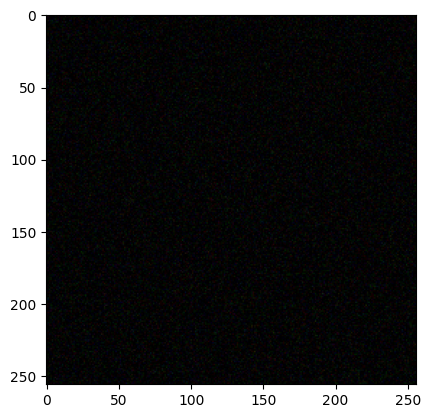

In [9]:
plt.imshow(model_output_reshaped.permute(1, 2, 0).detach().cpu())

In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(params=auto_encoder_model.parameters(),
                             lr=0.001)

image.shape

torch.Size([3, 256, 256])

In [11]:
flatten_image = nn.Flatten(start_dim=0)
flat_image = flatten_image(image)

flat_image = flat_image.to(device)
image = image.to(device)

flat_image.device, flat_image.shape

(device(type='cuda', index=0), torch.Size([196608]))

In [12]:
# Training the autoencoder

num_epochs = 15

for epoch in range(num_epochs):
    # forward pass
    
    reconstructed_image = auto_encoder_model(image)
    loss = criterion(reconstructed_image, flat_image)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    if (epoch+1) % 5 == 0:
        print(f'Epoch Count: {epoch+1}/{num_epochs} | Loss: {loss:.4f}')

Epoch Count: 5/15 | Loss: 0.6092
Epoch Count: 10/15 | Loss: 0.0885
Epoch Count: 15/15 | Loss: 0.3067


In [13]:
# plt.imshow(image.permute(1, 2, 0).cpu())
image.shape

torch.Size([3, 256, 256])

In [14]:
after_train_output = auto_encoder_model(image)

after_train_output = after_train_output.reshape(3, 256, 256)

In [15]:
after_train_output.device, after_train_output.shape


(device(type='cuda', index=0), torch.Size([3, 256, 256]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6777003..2.6363316].


Text(0.5, 1.0, 'Original Image')

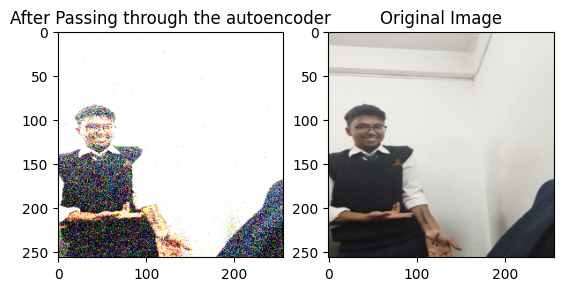

In [16]:
plt.subplot(1, 2, 1)
plt.imshow(after_train_output.permute(1, 2, 0).detach().cpu())
plt.title('After Passing through the autoencoder')

plt.subplot(1, 2, 2)
plt.imshow(image.permute(1, 2, 0).cpu())
plt.title('Original Image')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6777003..2.6363316].


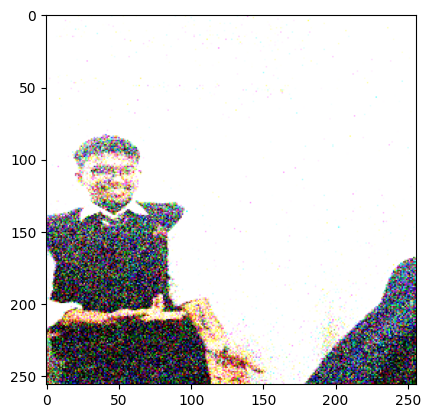

In [17]:
plt.imshow(after_train_output.permute(1, 2, 0).detach().cpu())

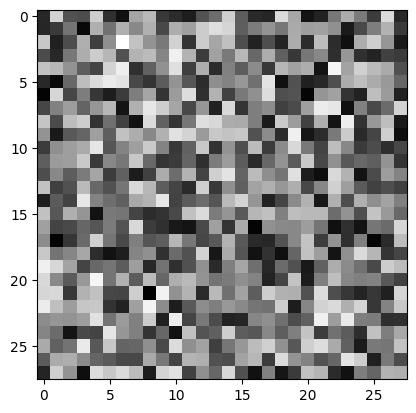

In [38]:
# Visualizing the output of only the encoder part of the model 

image.shape

output = auto_encoder_model.encoder(image)

output_reshaped = output.reshape(1, 28, 28).detach().cpu()

plt.imshow(output_reshaped.permute(1, 2, 0), cmap='grey')
